# Packages

In [1]:
! pip install lifelines scikit-survival survshap shap jinja2 survinsights seaborn numpy==1.23.5 

Defaulting to user installation because normal site-packages is not writeable


In [2]:
! pip install numba 

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import survshap
import seaborn as sns 
import survinsights

from sksurv.util import Surv
from sksurv.metrics import brier_score
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import integrated_brier_score
from sksurv.metrics import concordance_index_censored
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from sklearn.model_selection import train_test_split
from survinsights import local_explaination
from sklearn.preprocessing import LabelEncoder
#from survlimepy import SurvLimeExplainer

import time

import numba
import numpy as np
import sklearn.ensemble

import shap

import matplotlib.pyplot as plt
from sksurv.datasets import load_whas500
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from lifelines import KaplanMeierFitter
import numpy as np
import itertools
import random
from survinsights import local_explaination
from survinsights.explainer import explainer
from tqdm import tqdm

from scipy.integrate import simpson

import fonctions_SurvTreeShap as fstp

/home/onyxia/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Données

In [4]:
data = pd.read_csv("METABRIC_RNA_Mutation.csv")
data

/tmp/ipykernel_99507/1434437314.py:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("METABRIC_RNA_Mutation.csv")


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,7295,43.10,BREAST CONSERVING,Breast Cancer,Breast Invasive Lobular Carcinoma,High,0,LumA,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1900,7296,42.88,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1901,7297,62.90,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1902,7298,61.16,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,0,LumB,4.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [5]:
colones_00 = data.columns[520:]  # colones dont on veut faire passer 0 à "0", a partir de la colone "pik3ca_mut"
data[colones_00] = data[colones_00].astype(str)
data[colones_00] = data[colones_00].applymap(lambda x: 0 if x == "0" else 1)

/tmp/ipykernel_99507/1479749344.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data[colones_00] = data[colones_00].applymap(lambda x: 0 if x == "0" else 1)


In [6]:
for col in data.select_dtypes(include=['object']).columns:
    data[col] = LabelEncoder().fit_transform(data[col])

In [7]:
y = data[["death_from_cancer", "overall_survival_months"]]
y['Died_of_Desease'] = (y['death_from_cancer'] == 0).astype(int)
y=y.drop("death_from_cancer", axis=1)
y.head()

/tmp/ipykernel_99507/1315501560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Died_of_Desease'] = (y['death_from_cancer'] == 0).astype(int)


,overall_survival_months,Died_of_Desease
0,140.500000,0
1,84.633333,0
2,163.700000,1
3,164.933333,0
4,41.366667,1


In [8]:
X = data.drop(columns=["death_from_cancer", "overall_survival_months", "overall_survival"]) 

# RSF

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
y_train_RSF = Surv.from_dataframe("Died_of_Desease", "overall_survival_months", y_train)
y_test_RSF = Surv.from_dataframe("Died_of_Desease", "overall_survival_months", y_test)

In [11]:
rsf = RandomSurvivalForest(n_estimators=100, random_state=42,max_depth=3)
rsf.fit(X_train, y_train_RSF)

RandomSurvivalForest(max_depth=3, random_state=42)

# Performance

In [12]:
times = np.arange(2, 337)

In [13]:
# Prédire les fonctions de survie
survs = rsf.predict_survival_function(X_test)

preds = np.asarray([[fn(t) for t in times] for fn in survs])
score = integrated_brier_score(y_train_RSF, y_test_RSF, preds, times)
print(score)

0.17259456392030215


In [14]:
y_pred_rsf = rsf.predict(X_test)
c_index = concordance_index_censored(y_test_RSF["Died_of_Desease"], y_test_RSF["overall_survival_months"], y_pred_rsf)[0]
c_index

0.7271034563016409

# Résultat

In [15]:
x,y = fstp.Shapvalues(model= rsf, data=X_test.iloc[0, :], times=None)

  0%|          | 0/1374 [00:00<?, ?it/s]

100%|██████████| 1374/1374 [00:04<00:00, 290.42it/s]


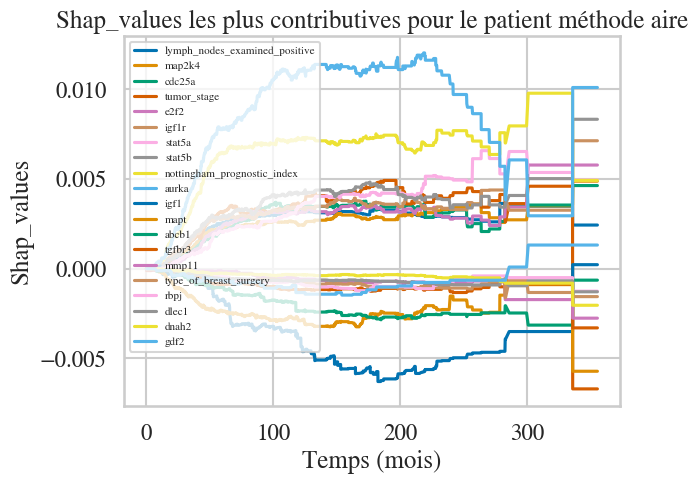

In [16]:
fstp.STP_graph(x=x, y=y, columns=list(X.columns), selection="area", min=10, max=10)

In [17]:
fstp.Shapvaluesrank(model= rsf, data=X_test, times=None, sample_size=2, number_of_values=10 )

100%|██████████| 1374/1374 [00:04<00:00, 314.33it/s]


[(1, 'nottingham_prognostic_index', 2.0723952854189767),
 (2, 'aurka', 1.7388238471888982),
 (3, 'mapt', 1.429364962872875),
 (4, 'stat5a', 1.2267893107213554),
 (5, 'igf1r', 1.1032739115050436),
 (6, 'lymph_nodes_examined_positive', 1.0189334803077974),
 (7, 'tumor_stage', 0.8705072484906091),
 (8, 'map2k4', 0.8579814132741894),
 (9, 'stat5b', 0.799136222387122),
 (10, 'e2f2', 0.761096180481586)]

# Test comutation PIK3CA-TP53

In [18]:
X_comp= X[["age_at_diagnosis", "tumor_stage", 'er_status', "her2_status", "pik3ca_mut", "tp53_mut"]]
X_comp['comutation'] = ((X_comp['pik3ca_mut'] == 1) & (X_comp['tp53_mut'] == 1)).astype(int)
X_comp

/tmp/ipykernel_99507/1030232619.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_comp['comutation'] = ((X_comp['pik3ca_mut'] == 1) & (X_comp['tp53_mut'] == 1)).astype(int)


,age_at_diagnosis,tumor_stage,er_status,her2_status,pik3ca_mut,tp53_mut,comutation
0,75.65,2.0,1,0,0,0,0
1,43.19,1.0,1,0,0,1,0
2,48.87,2.0,1,0,1,0,0
3,47.68,2.0,1,0,1,0,0
4,76.97,2.0,1,0,0,1,0
...,...,...,...,...,...,...,...
1899,43.10,NaN,1,0,1,0,0
1900,42.88,NaN,1,1,0,1,0
1901,62.90,NaN,1,0,0,0,0
1902,61.16,NaN,1,0,0,0,0


In [19]:
y = data[["death_from_cancer", "overall_survival_months"]]
y['Died_of_Desease'] = (y['death_from_cancer'] == 0).astype(int)
y=y.drop("death_from_cancer", axis=1)

/tmp/ipykernel_99507/3061523463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Died_of_Desease'] = (y['death_from_cancer'] == 0).astype(int)


In [20]:
X_comp_train, X_comp_test, y_train, y_test = train_test_split(X_comp, y, test_size=0.2, random_state=42)
y_train_RSF = Surv.from_dataframe("Died_of_Desease", "overall_survival_months", y_train)
y_test_RSF = Surv.from_dataframe("Died_of_Desease", "overall_survival_months", y_test)

In [21]:
rsf = RandomSurvivalForest(n_estimators=100, random_state=42, max_depth=3)
rsf.fit(X_comp_train, y_train_RSF)

RandomSurvivalForest(max_depth=3, random_state=42)

In [22]:
comutés = X_comp_test[X_comp_test["comutation"] == 1]

100%|██████████| 1374/1374 [00:04<00:00, 312.70it/s]


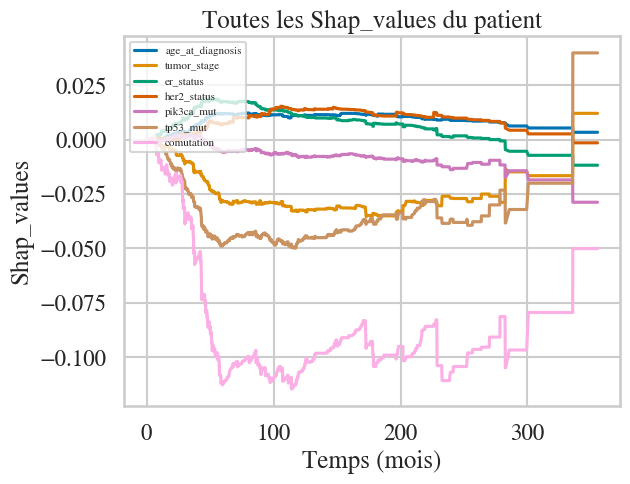

In [23]:
x,y = fstp.Shapvalues(model= rsf, data=comutés.iloc[0, :], times=None)
fstp.STP_graph(x=x, y=y, columns=list(comutés.columns), selection=None, min=10, max=10)

In [24]:
fstp.Shapvaluesrank(model= rsf, data=comutés, times=None, sample_size=2, number_of_values=None )

100%|██████████| 1374/1374 [00:04<00:00, 288.52it/s]


[(1, 'comutation', 32.22409005647738),
 (2, 'tp53_mut', 12.267813524548911),
 (3, 'tumor_stage', 8.09736546650753),
 (4, 'pik3ca_mut', 3.5439790227612304),
 (5, 'her2_status', 3.0583376441822856),
 (6, 'er_status', 3.0309216529856435),
 (7, 'age_at_diagnosis', 2.1945314143581385)]